# Gaussian Process

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import gp_utilities as gp_utils
from gp_utilities import *
# NEW
import tensorflow as tf

# COMPAT
#import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 160
plt.rcParams['lines.linewidth'] = 0.75
plt.rcParams['text.usetex'] = True
colors = sns.color_palette("viridis", 10)

# Abbreviations
tfd = tfp.distributions
#tfk = tfp.positive_semidefinite_kernels
tfk = tfp.math.psd_kernels

In [2]:
for i, color in enumerate(colors):
    value = np.array(color)
    value_rounded = np.around(value, decimals=2)
    value_int = np.around(value*255, decimals=0)
    value_int = "".join([hex(int(val))[2:4] for val in value_int])
    print(f"Viridis{i}")
    print(value_rounded)
    print(value_int)
    print()

Viridis0
[0.28 0.13 0.45]
482173

Viridis1
[0.26 0.24 0.52]
433e85

Viridis2
[0.22 0.34 0.55]
38588c

Viridis3
[0.18 0.44 0.56]
2d708e

Viridis4
[0.14 0.52 0.56]
25858e

Viridis5
[0.12 0.61 0.54]
1e9b8a

Viridis6
[0.17 0.69 0.5 ]
2ab07f

Viridis7
[0.32 0.77 0.41]
52c569

Viridis8
[0.53 0.83 0.29]
86d549

Viridis9
[0.76 0.88 0.14]
c2df23



In [3]:
np.array(colors[8])*255

array([134.07288 , 212.540205,  73.472385])

In [4]:
np.array(colors[7])*255

array([ 81.551295, 196.58307 , 104.84376 ])

In [5]:
np.array(colors[0])*255

array([ 72.18336 ,  33.378225, 114.556455])

In [6]:
np.array(colors[1])*255

array([ 66.84519 ,  61.78293 , 132.813435])

In [7]:
np.array(colors[2])*255

array([ 56.114535,  87.543285, 140.100315])

In [8]:
# Setup parameters
data_dir = "../data/"
save_path_train = f"{data_dir}preprocessed/gdansk_complete_deep_regression_seconds_original_train.csv"

# Hyperparameters
seed = 42
epochs = 10_000
learning_rate = 0.001

In [9]:
np.random.seed(seed)
# COMPAT
#tf.set_random_seed(42)
# NEW
tf.random.set_seed(seed)

In [10]:
print(tf.__version__)
tf.config.list_physical_devices()

2.1.0


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data

In the beginning we will just take one time series and split it into multiple parts so we can make sure its actually coming from the same patient.
This makes simulation easier. Later on we have to find a way to find to all all, but thats left for discussion.

We will also artificially remove some parts of the data so see how the GP handles the missing data. We will also not pass around `50` future values to the GP, to see how it handles forecasting.

In [11]:
%%time
train = pd.read_csv(save_path_train, nrows=10)
train

CPU times: user 2.67 s, sys: 31.9 ms, total: 2.7 s
Wall time: 2.72 s


,Unnamed: 0,age,rr1,rr2,rr3,rr4,rr5,rr6,rr7,rr8,...,rr26991,rr26992,rr26993,rr26994,rr26995,rr26996,rr26997,rr26998,rr26999,rr27000
0,0,55,1.016,1.000,1.016,1.032,1.008,1.024,1.024,1.032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,55,1.024,0.992,0.976,0.952,0.936,0.992,0.992,0.952,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,25,0.864,0.840,0.896,0.944,0.896,0.824,0.824,0.888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,45,0.840,0.832,0.832,0.848,0.824,0.832,0.808,0.824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,75,0.888,0.888,0.888,0.896,0.920,0.904,0.888,0.888,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,55,0.960,0.896,0.928,1.048,1.088,1.064,1.040,1.024,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6,65,0.880,0.880,0.872,0.920,0.936,0.920,0.896,0.912,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,55,0.992,0.984,0.952,0.984,0.952,0.952,0.944,0.952,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8,25,0.720,0.712,0.744,0.752,0.784,0.832,0.872,0.904,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,9,25,0.912,0.944,0.928,0.896,0.952,0.944,0.936,0.920,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
N = 250
from_gap = 65
to_gap = 80
sseries = train.iloc[0][2:].dropna(inplace=False)[0:N]
part_a = sseries[0:from_gap]
part_b = sseries[to_gap:(N-50)]
indices_a = list(range(0, from_gap))
indices_b = list(range(to_gap, (N-50)))
missing_a = sseries[(from_gap-1):(to_gap+1)]
missing_indices_a = list(range((from_gap-1), (to_gap+1)))
missing_b = sseries[(N-50):N]
missing_indices_b = list(range((N-50), N))

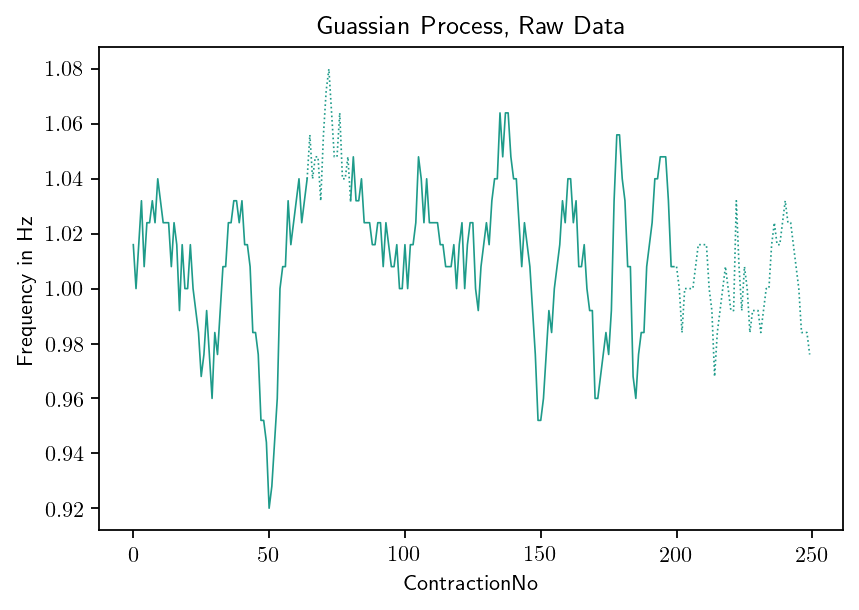

In [13]:
plt.plot(indices_a, part_a, color=colors[5]);
plt.plot(indices_b, part_b, color=colors[5]);
plt.plot(missing_indices_a, missing_a, color=colors[5], linestyle=":");
plt.plot(missing_indices_b, missing_b, color=colors[5], linestyle=":");
plt.title('Guassian Process, Raw Data');
plt.ylabel('Frequency in Hz');
plt.xlabel('ContractionNo');

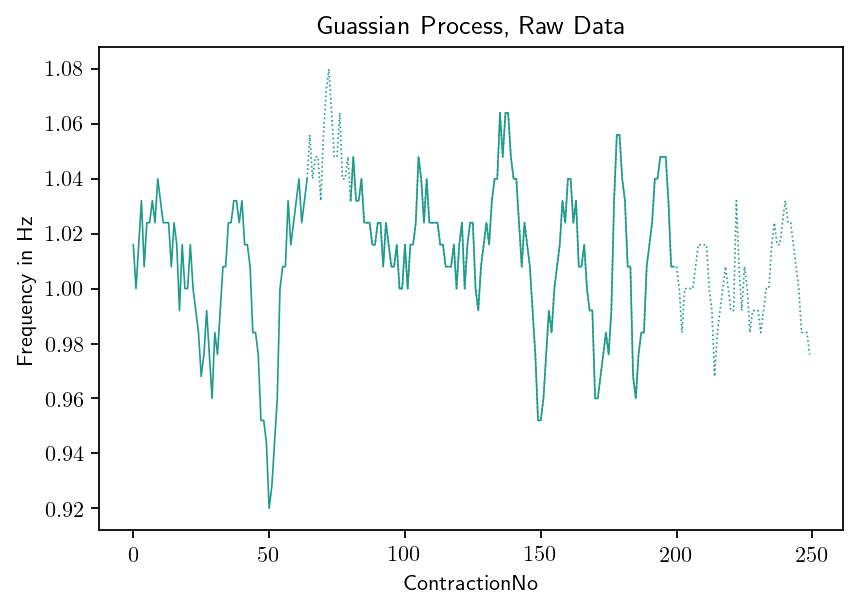

In [14]:
plt.plot(indices_a, part_a, color=colors[5]);
plt.plot(indices_b, part_b, color=colors[5]);
plt.plot(indices_b, part_b, color=colors[5], linestyle=":");
plt.plot(missing_indices_a, missing_a, color=colors[5], linestyle=":");
plt.plot(missing_indices_b, missing_b, color=colors[5], linestyle=":");
plt.title('Guassian Process, Raw Data');
plt.ylabel('Frequency in Hz');
plt.xlabel('ContractionNo');

In [15]:
sseries = list(part_a) + list(part_b)
indices = list(indices_a) + list(indices_b)

## Gaussian Process

### Observations

In [16]:
X_train = np.array(indices, dtype=float).reshape(-1, 1)
Y_train = np.array(sseries, dtype=float)

### Gaussian Prior & Kernel

In [17]:
def get_slo_kernel(smooth_amplitude, smooth_length_scale,
                    periodic_amplitude, periodic_length_scale, periodic_period, periodic_local_amplitude, periodic_local_length_scale,
                    global_periodic_amplitude, global_periodic_length_scale, global_periodic_period,
                    irregular_amplitude, irregular_length_scale, irregular_scale_mixture,
                    matern_onehalf_amplitude, matern_onehalf_length_scale,
                    matern_threehalves_amplitude, matern_threehalves_length_scale,
                    matern_fivehalves_amplitude, matern_fivehalves_length_scale):
    
    # Smooth kernel
    smooth_kernel = tfk.ExponentiatedQuadratic(
        amplitude=smooth_amplitude,
        length_scale=smooth_length_scale)
    
    # Local periodic kernel
    local_periodic_kernel = (
        tfk.ExpSinSquared(
            amplitude=periodic_amplitude, 
            length_scale=periodic_length_scale,
            period=periodic_period) * 
        tfk.ExponentiatedQuadratic(
            amplitude=periodic_local_amplitude,
            length_scale=periodic_local_length_scale))
    
    # Periodic
    global_periodic_kernel = tfk.ExpSinSquared(
            amplitude=global_periodic_amplitude, 
            length_scale=global_periodic_length_scale,
            period=global_periodic_period)
    
    # Irregular kernel
    irregular_kernel = tfk.RationalQuadratic(
        amplitude=irregular_amplitude,
        length_scale=irregular_length_scale,
        scale_mixture_rate=irregular_scale_mixture)
    
    # Matern 1/2
    matern_onehalf_kernel = tfk.MaternOneHalf(
        amplitude = matern_onehalf_amplitude,
        length_scale = matern_onehalf_length_scale
    )
    
    # Matern 3/2
    matern_fivehalf_kernel = tfk.MaternThreeHalves(
        amplitude = matern_threehalves_amplitude,
        length_scale = matern_threehalves_length_scale
    )
    
    # Matern 5/2
    matern_fivehalf_kernel = tfk.MaternFiveHalves(
        amplitude = matern_fivehalves_amplitude,
        length_scale = matern_fivehalves_length_scale
    )
    
    return smooth_kernel + local_periodic_kernel + irregular_kernel + matern_onehalf_kernel + matern_fivehalf_kernel + matern_fivehalf_kernel

In [18]:
def build_gp(smooth_amplitude, smooth_length_scale,
              periodic_amplitude, periodic_length_scale, periodic_period, periodic_local_amplitude, periodic_local_length_scale,
              global_periodic_amplitude, global_periodic_length_scale, global_periodic_period,
              irregular_amplitude, irregular_length_scale, irregular_scale_mixture,
              matern_onehalf_amplitude, matern_onehalf_length_scale,
              matern_threehalves_amplitude, matern_threehalves_length_scale,
              matern_fivehalves_amplitude, matern_fivehalves_length_scale,
              observation_noise_variance):
    """Defines the conditional dist. of GP outputs, given kernel parameters."""

    # Create the covariance kernel, which will be shared between the prior (which we
    # use for maximum likelihood training) and the posterior (which we use for
    # posterior predictive sampling)
    kernel = get_slo_kernel(smooth_amplitude, smooth_length_scale,
              periodic_amplitude, periodic_length_scale, periodic_period, periodic_local_amplitude, periodic_local_length_scale,
              global_periodic_amplitude, global_periodic_length_scale, global_periodic_period,
              irregular_amplitude, irregular_length_scale, irregular_scale_mixture,
              matern_onehalf_amplitude, matern_onehalf_length_scale,
              matern_threehalves_amplitude, matern_threehalves_length_scale,
              matern_fivehalves_amplitude, matern_fivehalves_length_scale)
    #kernel = tfk.ExponentiatedQuadratic(periodic_amplitude, periodic_length_scale)
    # Create the GP prior distribution, which we will use to train the model
    # parameters.
    return tfd.GaussianProcess(
      mean_fn=lambda x: np.mean(Y_train),
      kernel=kernel,
      index_points=X_train,
      observation_noise_variance=observation_noise_variance)

In [19]:
gp_joint_model = tfd.JointDistributionNamed({
    'smooth_amplitude': tfd.LogNormal(loc=0., scale=np.float64(1)),
    'smooth_length_scale': tfd.LogNormal(loc=0., scale=np.float64(1)),
    'periodic_amplitude': tfd.LogNormal(loc=0., scale=np.float64(1)),
    'periodic_length_scale': tfd.LogNormal(loc=0., scale=np.float64(1)),
    'periodic_period': tfd.LogNormal(loc=0., scale=np.float64(1)),
    'periodic_local_amplitude': tfd.LogNormal(loc=0., scale=np.float64(1)),
    'periodic_local_length_scale': tfd.LogNormal(loc=0., scale=np.float64(1)),
    'global_periodic_amplitude': tfd.LogNormal(loc=0., scale=np.float64(1)),
    'global_periodic_length_scale': tfd.LogNormal(loc=0.016, scale=np.float64(1)),
    'global_periodic_period': tfd.LogNormal(loc=2., scale=np.float64(1)),
    'irregular_amplitude': tfd.LogNormal(loc=0., scale=np.float64(1)),
    'irregular_length_scale': tfd.LogNormal(loc=0., scale=np.float64(1)),
    'irregular_scale_mixture': tfd.LogNormal(loc=0., scale=np.float64(1)),
    'matern_onehalf_amplitude': tfd.LogNormal(loc=0., scale=np.float64(1)),
    'matern_onehalf_length_scale': tfd.LogNormal(loc=0., scale=np.float64(1)),
    'matern_threehalves_amplitude': tfd.LogNormal(loc=0., scale=np.float64(1)),
    'matern_threehalves_length_scale': tfd.LogNormal(loc=0., scale=np.float64(1)),
    'matern_fivehalves_amplitude': tfd.LogNormal(loc=0., scale=np.float64(1)),
    'matern_fivehalves_length_scale': tfd.LogNormal(loc=0., scale=np.float64(1)),
    'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1)),
    'observations': build_gp,
})

In [20]:
gp_joint_model.sample()

{'smooth_length_scale': <tf.Tensor: shape=(), dtype=float64, numpy=0.25670503505264636>,
 'smooth_amplitude': <tf.Tensor: shape=(), dtype=float64, numpy=1.4571535911127294>,
 'periodic_period': <tf.Tensor: shape=(), dtype=float64, numpy=1.3365436204966228>,
 'periodic_local_length_scale': <tf.Tensor: shape=(), dtype=float64, numpy=0.8743446900585751>,
 'periodic_local_amplitude': <tf.Tensor: shape=(), dtype=float64, numpy=0.7477451528273873>,
 'periodic_length_scale': <tf.Tensor: shape=(), dtype=float64, numpy=0.8694074175000961>,
 'periodic_amplitude': <tf.Tensor: shape=(), dtype=float64, numpy=0.8220164817303733>,
 'observation_noise_variance': <tf.Tensor: shape=(), dtype=float64, numpy=0.17680667681427312>,
 'matern_threehalves_length_scale': <tf.Tensor: shape=(), dtype=float64, numpy=0.8176222004819234>,
 'matern_threehalves_amplitude': <tf.Tensor: shape=(), dtype=float64, numpy=11.647381401821551>,
 'matern_onehalf_length_scale': <tf.Tensor: shape=(), dtype=float64, numpy=0.477117

In [21]:
x = gp_joint_model.sample()
lp = gp_joint_model.log_prob(x)

#print("sampled {}".format(x))
print("log_prob of sample: {}".format(lp))

log_prob of sample: -564.8974459931087


In [22]:
# Create the trainable model parameters, which we'll subsequently optimize.
# Note that we constrain them to be strictly positive.

constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

smooth_amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='smooth_amplitude',
    dtype=np.float64)

smooth_length_scale_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='smooth_length_scale',
    dtype=np.float64)

periodic_amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='periodic_amplitude',
    dtype=np.float64)

periodic_length_scale_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='periodic_length_scale',
    dtype=np.float64)

periodic_period_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='periodic_period',
    dtype=np.float64)

periodic_local_amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='periodic_local_amplitude',
    dtype=np.float64)

periodic_local_length_scale_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='periodic_local_length_scale',
    dtype=np.float64)

global_periodic_amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='periodic_amplitude',
    dtype=np.float64)

global_periodic_length_scale_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='periodic_length_scale',
    dtype=np.float64)

global_periodic_period_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='periodic_period',
    dtype=np.float64)

irregular_amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='irregular_amplitude',
    dtype=np.float64)

irregular_length_scale_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='irregular_length_scale',
    dtype=np.float64)

irregular_scale_mixture_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='irregular_scale_mixture',
    dtype=np.float64)

observation_noise_variance_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='observation_noise_variance',
    dtype=np.float64)

matern_onehalf_amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='matern_onehalf_amplitude',
    dtype=np.float64)

matern_onehalf_scale_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='matern_onehalf_length_scale',
    dtype=np.float64)

matern_threehalves_amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='matern_threehalves_amplitude',
    dtype=np.float64)

matern_threehalves_scale_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='matern_threehalves_length_scale',
    dtype=np.float64)

matern_fivehalves_amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='matern_fivehalves_amplitude',
    dtype=np.float64)

matern_fivehalves_scale_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='matern_fivehalves_length_scale',
    dtype=np.float64)

trainable_variables = [v.trainable_variables[0] for v in 
                       [smooth_amplitude_var,
                       smooth_length_scale_var,
                       periodic_amplitude_var,
                       periodic_length_scale_var,
                       periodic_period_var,
                       periodic_local_amplitude_var,
                       periodic_local_length_scale_var,
                       global_periodic_amplitude_var,
                       global_periodic_length_scale_var,
                       global_periodic_period_var,
                       irregular_amplitude_var,
                       irregular_length_scale_var,
                       irregular_scale_mixture_var,
                       observation_noise_variance_var,
                       matern_onehalf_amplitude_var,
                       matern_onehalf_scale_var,
                       matern_threehalves_amplitude_var,
                       matern_threehalves_scale_var,
                       matern_fivehalves_amplitude_var,
                       matern_fivehalves_scale_var]]

In [23]:
# Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False, experimental_compile=False)
def target_log_prob(smooth_amplitude_var,
                       smooth_length_scale_var,
                       periodic_amplitude_var,
                       periodic_length_scale_var,
                       periodic_period_var,
                       periodic_local_amplitude_var,
                       periodic_local_length_scale_var,
                       global_periodic_amplitude_var,
                       global_periodic_length_scale_var,
                       global_periodic_period_var,
                       irregular_amplitude_var,
                       irregular_length_scale_var,
                       irregular_scale_mixture_var,
                       matern_onehalf_amplitude_var,
                       matern_onehalf_scale_var,
                       matern_threehalves_amplitude_var,
                       matern_threehalves_scale_var,
                       matern_fivehalves_amplitude_var,
                       matern_fivehalves_scale_var,
                       observation_noise_variance_var):
    
    return gp_joint_model.log_prob({
      'smooth_amplitude': smooth_amplitude_var,
      'smooth_length_scale': smooth_length_scale_var,
      'periodic_amplitude': periodic_amplitude_var,
      'periodic_length_scale': periodic_length_scale_var,
      'periodic_period': periodic_period_var,
      'periodic_local_amplitude': periodic_local_amplitude_var,
      'periodic_local_length_scale': periodic_local_length_scale_var,
      'global_periodic_amplitude': global_periodic_amplitude_var,
      'global_periodic_length_scale': global_periodic_length_scale_var,
      'global_periodic_period': global_periodic_period_var,
      'irregular_amplitude': irregular_amplitude_var,
      'irregular_length_scale': irregular_length_scale_var,
      'irregular_scale_mixture': irregular_scale_mixture_var,
      'matern_onehalf_amplitude': matern_onehalf_amplitude_var,
      'matern_onehalf_length_scale': matern_onehalf_scale_var,
      'matern_threehalves_amplitude': matern_threehalves_amplitude_var,
      'matern_threehalves_length_scale': matern_threehalves_scale_var,
      'matern_fivehalves_amplitude': matern_fivehalves_amplitude_var,
      'matern_fivehalves_length_scale': matern_fivehalves_scale_var,
      'observation_noise_variance': observation_noise_variance_var,
      'observations': Y_train
    })

### Gradient Descent for Point Estimates

In [24]:
%%time
with tf.device('/gpu:0'):
    # Now we optimize the model parameters.
    num_iters = epochs
    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

    # Store the likelihood values during training, so we can plot the progress
    lls_ = np.zeros(num_iters, np.float64)
    for i in range(num_iters):

        # Status
        if i != 0:
            print(f"{str(round(i/num_iters*100, 2))}%, Loss: {lls_[i-1]}", end="\r")

        with tf.GradientTape() as tape:
            loss = -target_log_prob(smooth_amplitude_var,
                           smooth_length_scale_var,
                           periodic_amplitude_var,
                           periodic_length_scale_var,
                           periodic_period_var,
                           periodic_local_amplitude_var,
                           periodic_local_length_scale_var,
                           global_periodic_amplitude_var,
                           global_periodic_length_scale_var,
                           global_periodic_period_var,
                           irregular_amplitude_var,
                           irregular_length_scale_var,
                           irregular_scale_mixture_var,
                           matern_onehalf_amplitude_var,
                           matern_onehalf_scale_var,
                           matern_threehalves_amplitude_var,
                           matern_threehalves_scale_var,
                           matern_fivehalves_amplitude_var,
                           matern_fivehalves_scale_var,
                           observation_noise_variance_var)
            grads = tape.gradient(loss, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables))
            lls_[i] = loss

print('Trained parameters:')
print('smooth_amplitude: {}'.format(smooth_amplitude_var._value().numpy()))
print('smooth_length_scale: {}'.format(smooth_length_scale_var._value().numpy()))
print('periodic_amplitude: {}'.format(periodic_amplitude_var._value().numpy()))
print('periodic_length_scale: {}'.format(periodic_length_scale_var._value().numpy()))
print('periodic_period: {}'.format(periodic_period_var._value().numpy()))
print('periodic_local_amplitude: {}'.format(periodic_local_amplitude_var._value().numpy()))
print('periodic_local_length_scale: {}'.format(periodic_local_length_scale_var._value().numpy()))
print('global_periodic_amplitude: {}'.format(global_periodic_amplitude_var._value().numpy()))
print('global_periodic_length_scale: {}'.format(global_periodic_length_scale_var._value().numpy()))
print('global_periodic_period: {}'.format(global_periodic_period_var._value().numpy()))
print('irregular_amplitude: {}'.format(irregular_amplitude_var._value().numpy()))
print('irregular_length_scale: {}'.format(irregular_length_scale_var._value().numpy()))
print('irregular_scale_mixture: {}'.format(irregular_scale_mixture_var._value().numpy()))
print('matern_onehalf_amplitude: {}'.format(matern_onehalf_amplitude_var._value().numpy()))
print('matern_onehalf_scale: {}'.format(matern_onehalf_scale_var._value().numpy()))
print('matern_threehalves_amplitude: {}'.format(matern_threehalves_amplitude_var._value().numpy()))
print('matern_threehalves_scale: {}'.format(matern_threehalves_scale_var._value().numpy()))
print('matern_fivehalves_amplitude: {}'.format(matern_fivehalves_amplitude_var._value().numpy()))
print('matern_fivehalves_scale: {}'.format(matern_fivehalves_scale_var._value().numpy()))
print('observation_noise_variance: {}'.format(observation_noise_variance_var._value().numpy()))

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Trained parameters:9837001531715461
smooth_amplitude: 0.021854665592977836
smooth_length_scale: 4.2588876554564825
periodic_amplitude: 0.05387198576409192
periodic_length_scale: 0.3679243361111636
periodic_period: 0.49980015957564133
periodic_local_amplitude: 0.05387198576409192
periodic_local_length_scale: 0.8774408675206453
global_periodic_amplitude: 0.3678794411714424
global_periodic_length_scale: 0.37381285294546657
global_periodic_period: 2.7182818284590446
irregular_amplitude: 0.01416396988294803
irregular_length_scale: 4.146611585773073
irregular_scale_mixture: 0.6015559752066347
matern_onehalf_amplitude: 0.004795200159066785
matern_onehalf_scale: 1.832663754018536
matern_threehalves_amplitude: 0.3678794411714424
matern_threehalves_scale: 0.3678794411714424
matern_fivehalves_amplitude: 0.01162291185946003
matern_fivehalves_scale: 5.030183381753336
observation_noise_variance: 8.441068346451243e

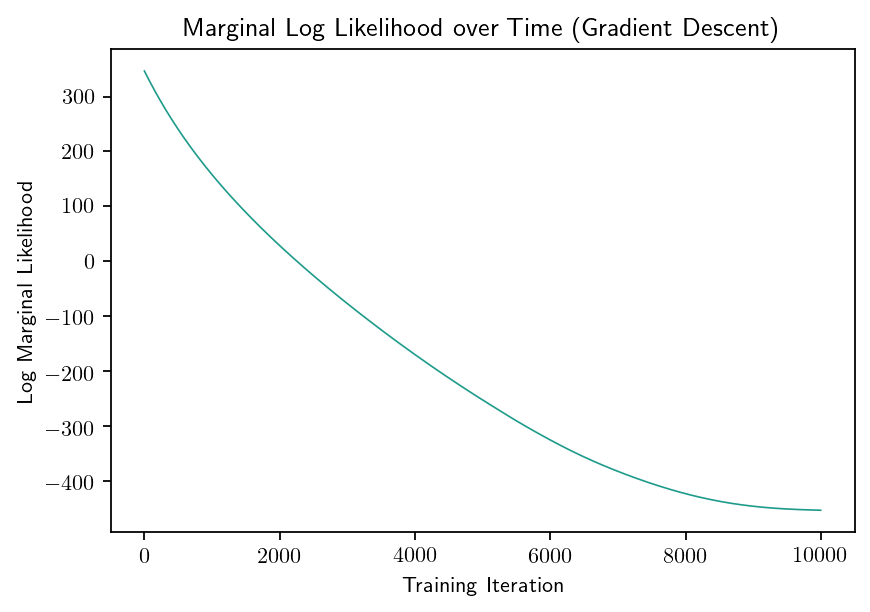

In [25]:
# Plot the loss evolution
plt.title("Marginal Log Likelihood over Time (Gradient Descent)")
plt.plot(lls_, color=colors[5])
plt.xlabel("Training Iteration")
plt.ylabel("Log Marginal Likelihood")
plt.show()

### Sampling an Plotting

In [26]:
# Having trained the model, we'd like to sample from the posterior conditioned
# on observations. We'd like the samples to be at points other than the training
# inputs.
predictive_index_points_ = np.linspace(0, N, N, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

optimized_kernel = get_slo_kernel(smooth_amplitude_var,
                       smooth_length_scale_var,
                       periodic_amplitude_var,
                       periodic_length_scale_var,
                       periodic_period_var,
                       periodic_local_amplitude_var,
                       periodic_local_length_scale_var,
                       global_periodic_amplitude_var,
                       global_periodic_length_scale_var,
                       global_periodic_period_var,
                       irregular_amplitude_var,
                       irregular_length_scale_var,
                       irregular_scale_mixture_var,
                       matern_onehalf_amplitude_var,
                       matern_onehalf_scale_var,
                       matern_threehalves_amplitude_var,
                       matern_threehalves_scale_var,
                       matern_fivehalves_amplitude_var,
                       matern_fivehalves_scale_var)

gprm = tfd.GaussianProcessRegressionModel(
    mean_fn=lambda x: np.mean(Y_train),
    kernel=optimized_kernel,
    index_points=predictive_index_points_,
    observation_index_points=X_train,
    observations=Y_train,
    observation_noise_variance=observation_noise_variance_var,
    predictive_noise_variance=0.)

# Create op to draw 50 independent samples, each of which is a *joint* draw
# from the posterior at the predictive_index_points_. Since we have 200 input
# locations as defined above, this posterior distribution over corresponding
# function values is a 200-dimensional multivariate Gaussian distribution!
num_samples = 50
samples = gprm.sample(num_samples)

In [27]:
gp_mean = tf.math.reduce_mean(samples, axis=0).numpy()
#gp_sd = tf.math.reduce_std(samples, axis=0).numpy()
gp_variance = tf.linalg.diag_part(
    gprm.covariance(),
    name='diag_part',
    k=0,
    padding_value=0
)
confidence_lower = gp_mean - 1.96 * tf.math.sqrt(gp_variance)
confidence_upper = gp_mean + 1.96 * tf.math.sqrt(gp_variance)
prediction_lower = gp_mean - 1.96 * tf.math.sqrt(gp_variance + observation_noise_variance_var)
prediction_upper = gp_mean + 1.96 * tf.math.sqrt(gp_variance + observation_noise_variance_var)

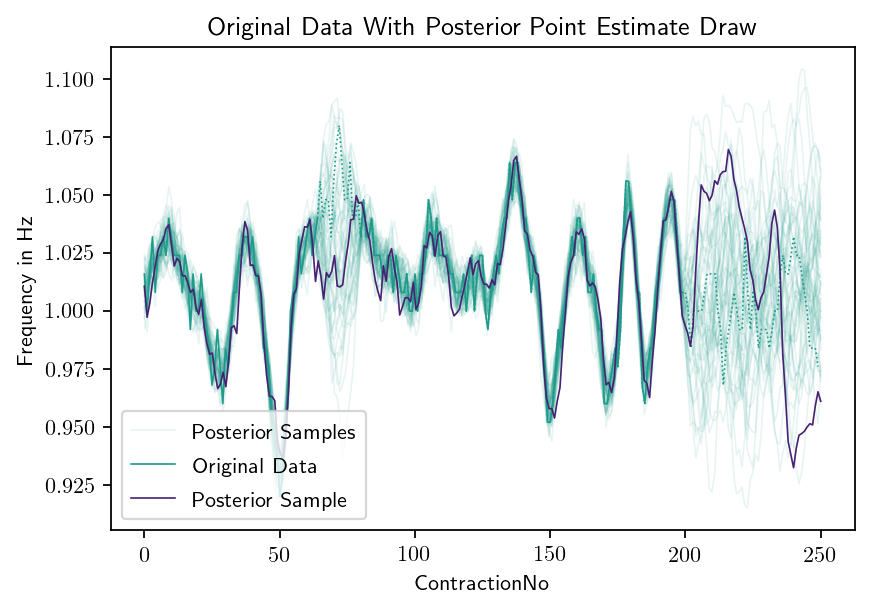

In [28]:
# Samples
for i in range(num_samples):
    plt.plot(predictive_index_points_, samples[i, :], c=colors[5], alpha=0.1,
           label='Posterior Samples' if i == 0 else None)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.plot(indices_a, part_a, color=colors[5], label="Original Data");
plt.plot(indices_b, part_b, color=colors[5]);
plt.plot(indices_b, part_b, color=colors[5], linestyle=":");
plt.plot(missing_indices_a, missing_a, color=colors[5], linestyle=":");
plt.plot(missing_indices_b, missing_b, color=colors[5], linestyle=":");

plt.plot(predictive_index_points_.flatten(), samples[5], label="Posterior Sample", color=colors[0]);

plt.legend(loc='lower left')
plt.title('Original Data With Posterior Point Estimate Draw');
plt.ylabel('Frequency in Hz');
plt.xlabel('ContractionNo');

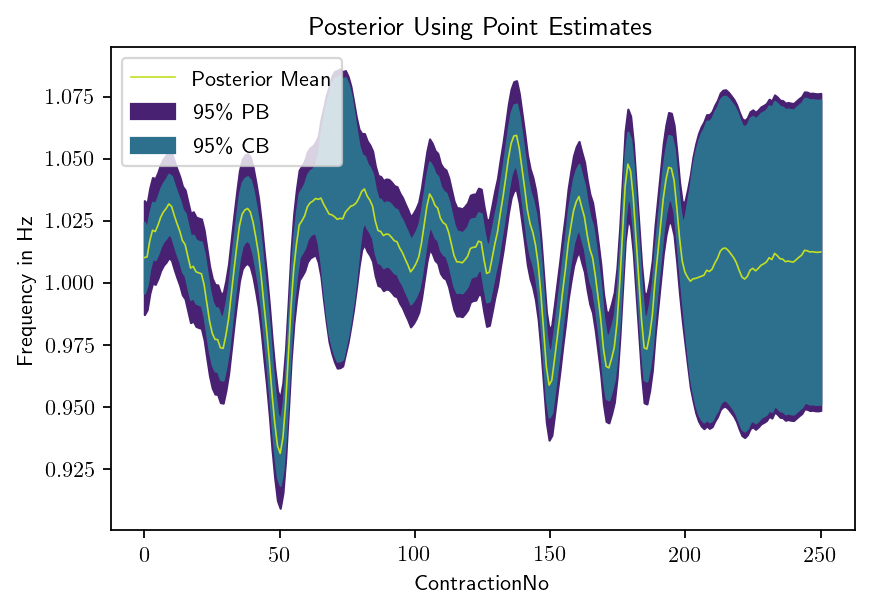

In [29]:
# CB and PB
plt.fill_between(predictive_index_points_.flatten(), prediction_lower, prediction_upper, color=colors[0], alpha=1.0, label="95\% PB")
plt.fill_between(predictive_index_points_.flatten(), confidence_lower, confidence_upper, color=colors[3], alpha=1.0, label="95\% CB")
plt.plot(predictive_index_points_.flatten(), gp_mean, color=colors[9], label="Posterior Mean")
plt.legend(loc='upper left')
plt.title('Posterior Using Point Estimates');
plt.ylabel('Frequency in Hz');
plt.xlabel('ContractionNo');

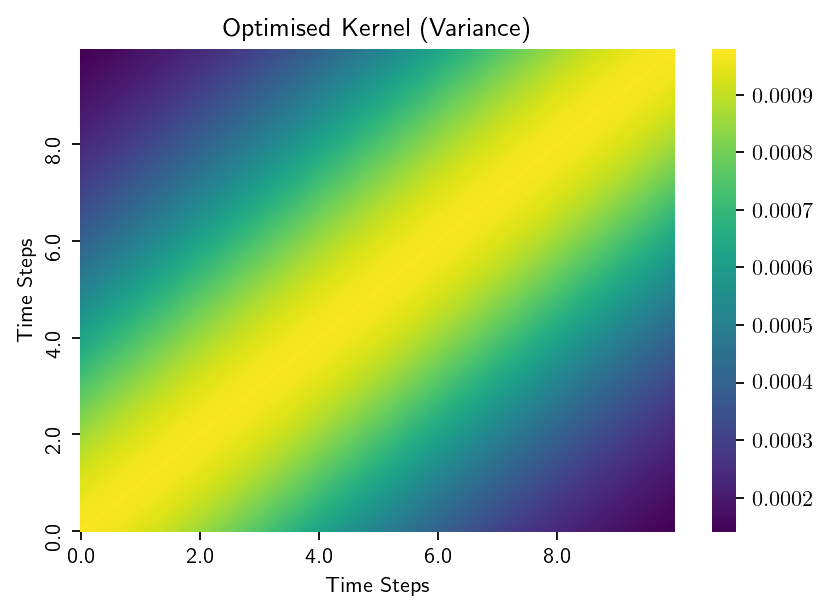

In [30]:
plot_kernel(optimized_kernel, title="Optimised Kernel (Variance)", xlabel="Time Steps", ylabel="Time Steps");

### Hamilton Monte Carlo

In [31]:
num_results = 100
num_burnin_steps = 500
num_steps_between_results = 10 # Makes the Cholesky Decomposition break...

sampler = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob,
        step_size=tf.cast(0.1, tf.float64),
        num_leapfrog_steps=8),
    bijector=[constrain_positive]*20)

adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=sampler,
    num_adaptation_steps=int(0.8 * num_burnin_steps),
    target_accept_prob=tf.cast(0.75, tf.float64))

initial_state = [tf.cast(x, tf.float64) for x in [1.]*20]

In [32]:
%%time

with tf.device('/gpu:0'):
    # Speed up sampling by tracing with `tf.function`.
    @tf.function(autograph=False, experimental_compile=False)
    def do_sampling():
        return tfp.mcmc.sample_chain(
          kernel=adaptive_sampler,
          current_state=initial_state,
          num_results=num_results,
          num_burnin_steps=num_burnin_steps,
          parallel_iterations=10,
          trace_fn=lambda current_state, kernel_results: kernel_results)

samples, kernel_results = do_sampling()

CPU times: user 1min 44s, sys: 5.23 s, total: 1min 49s
Wall time: 1min 26s


In [33]:
(smooth_amplitude_samples,
smooth_length_scale_samples,
periodic_amplitude_samples,
periodic_length_scale_samples,
periodic_period_samples,
periodic_local_amplitude_samples,
periodic_local_length_scale_samples,
global_periodic_amplitude_samples,
global_periodic_length_scale_samples,
global_periodic_period_samples,
irregular_amplitude_samples,
irregular_length_scale_samples,
irregular_scale_mixture_samples,
matern_onehalf_amplitude_samples,
matern_onehalf_scale_samples,
matern_threehalves_amplitude_samples,
matern_threehalves_scale_samples,
matern_fivehalves_amplitude_samples,
matern_fivehalves_scale_samples,
observation_noise_variance_samples) = samples

## Kernel Plotting

In [46]:
custom_dist = tfd.Empirical(smooth_amplitude_samples)

In [47]:
custom_dist

<tfp.distributions.Empirical 'Empirical_Empirical' batch_shape=[] event_shape=[] dtype=float64>

In [50]:
custom_dist.sample(100)

<tf.Tensor: shape=(100,), dtype=float64, numpy=
array([0.18751094, 0.03322551, 0.02551316, 0.0264054 , 0.05377991,
       0.07257892, 0.0394819 , 0.03258537, 0.01431462, 0.03980795,
       0.16184133, 0.18751094, 0.02850607, 0.02649474, 0.09706348,
       0.03044288, 0.02551316, 0.01431462, 0.02039496, 0.03152071,
       0.01725813, 0.05220255, 0.03980795, 0.04805458, 0.01431462,
       0.05300124, 0.05377991, 0.05220255, 0.02649474, 0.06701624,
       0.02099916, 0.02347044, 0.05300124, 0.03242763, 0.02592206,
       0.03242763, 0.10094749, 0.07257892, 0.03857257, 0.07241866,
       0.02312239, 0.07257892, 0.03384162, 0.02479632, 0.07440134,
       0.061855  , 0.07257892, 0.03258537, 0.07241866, 0.03258537,
       0.03044288, 0.02813574, 0.01431462, 0.01431462, 0.10094749,
       0.10444867, 0.02039496, 0.05377991, 0.07257892, 0.02479632,
       0.02347044, 0.05300124, 0.06316662, 0.02303015, 0.03258537,
       0.03980795, 0.03674288, 0.03980795, 0.07257892, 0.061855  ,
       0.03082

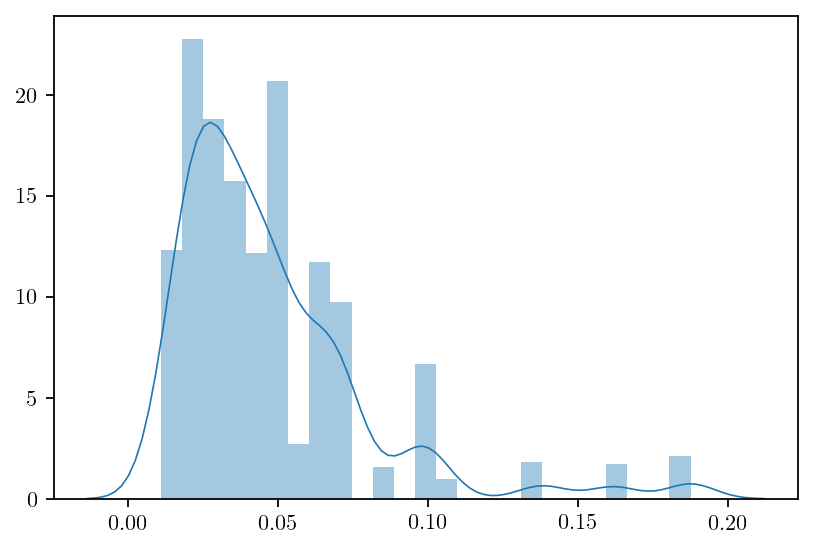

In [53]:
sns.distplot(custom_dist.sample(1000))

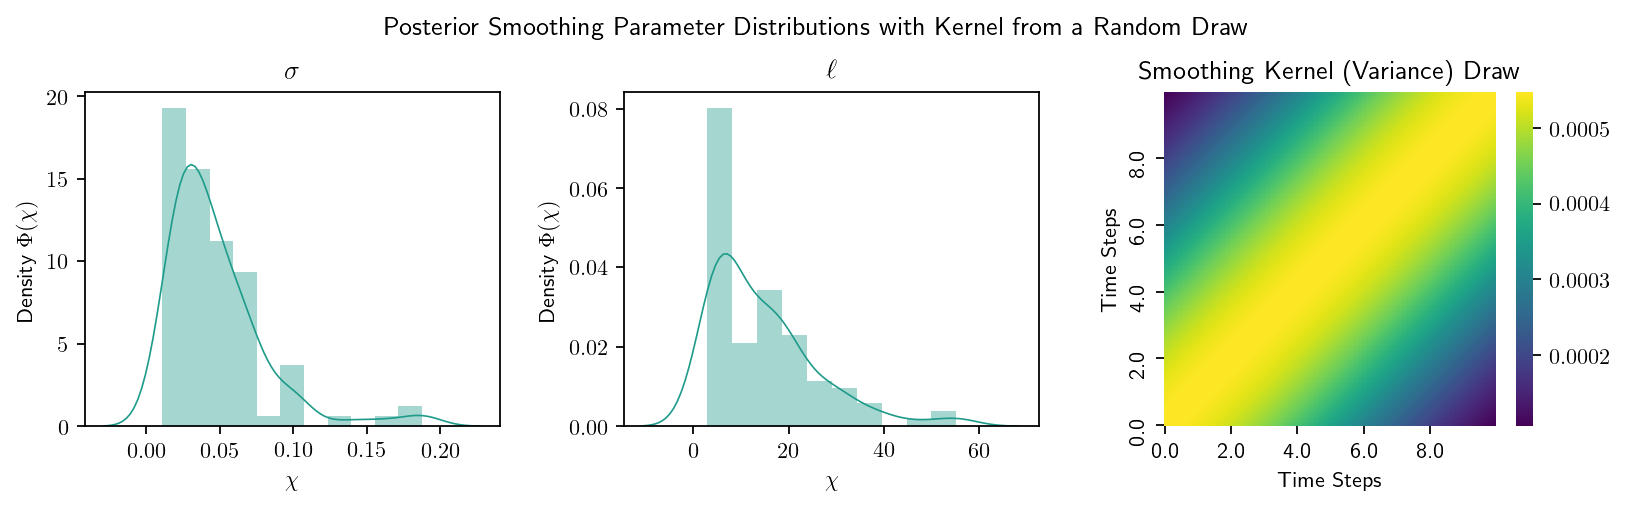

In [34]:
# Smooting
# Kernel
smooth_kernel = tfk.ExponentiatedQuadratic(
        amplitude=smooth_amplitude_samples[0],
        length_scale=smooth_length_scale_samples[0])

fig, axs = plt.subplots(1, 3, figsize=(10, 3))
plt.tight_layout(w_pad=3.0)
fig.subplots_adjust(top=0.82)
fig.suptitle('Posterior Smoothing Parameter Distributions with Kernel from a Random Draw')

sns.distplot(smooth_amplitude_samples, norm_hist=True, ax=axs[0], kde=True, color=colors[5])
axs[0].set_title(r'$\sigma$')
sns.distplot(smooth_length_scale_samples, norm_hist=True, ax=axs[1], kde=True, color=colors[5])
axs[1].set_title(r'$\ell$')
plot_kernel(smooth_kernel, title="Smoothing Kernel (Variance) Draw", xlabel="Time Steps", ylabel="Time Steps")

for i, ax in enumerate(axs.flat):
    if i != (len(axs.flat)-1):
        ax.set(xlabel=r'$\chi$', ylabel= r'Density $\Phi(\chi)$')

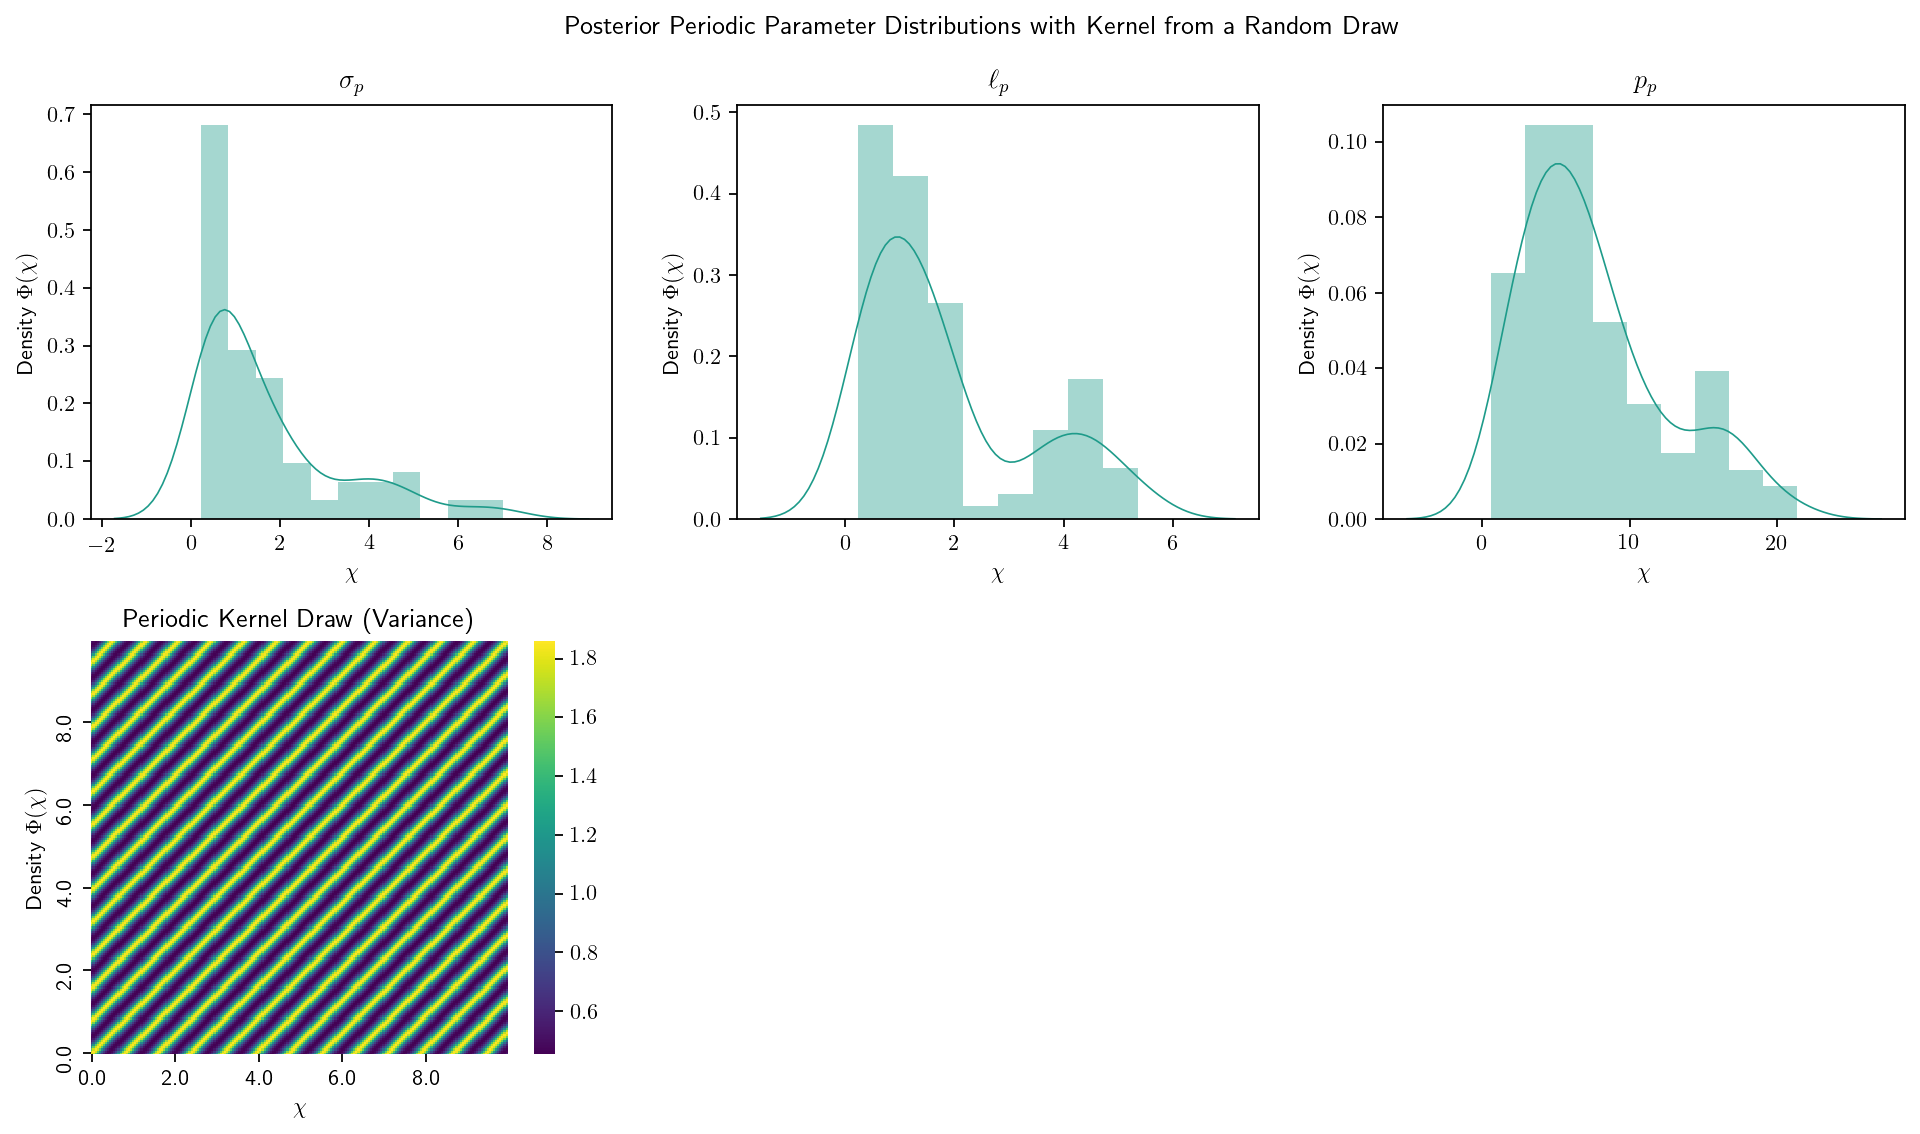

In [35]:
# Periodic
global_periodic_kernel = tfk.ExpSinSquared(
            amplitude=global_periodic_amplitude_samples[0], 
            length_scale=global_periodic_length_scale_samples[0],
            period=global_periodic_period_samples[0])

fig, axs = plt.subplots(2, 3, figsize=(12, 7))
plt.tight_layout(h_pad=4.0, w_pad=3.0)
fig.subplots_adjust(top=0.90)
fig.suptitle('Posterior Periodic Parameter Distributions with Kernel from a Random Draw')

sns.distplot(global_periodic_amplitude_samples, norm_hist=True, ax=axs[0,0], kde=True, color=colors[5])
axs[0,0].set_title(r'$\sigma_{p}$')
sns.distplot(global_periodic_length_scale_samples, norm_hist=True, ax=axs[0,1], kde=True, color=colors[5])
axs[0,1].set_title(r'$\ell_{p}$')
sns.distplot(global_periodic_period_samples, norm_hist=True, ax=axs[0,2], kde=True, color=colors[5])
axs[0,2].set_title(r'$p_{p}$')
plot_kernel(global_periodic_kernel,
            title="Periodic Kernel Draw (Variance)",
            xlabel="Time Steps",
            ylabel="Time Steps",
            ax=axs[1,0])

for i, ax in enumerate(axs.flat):
    if i != (len(axs.flat)-1):
        ax.set(xlabel=r'$\chi$', ylabel= r'Density $\Phi(\chi)$')
        
fig.delaxes(axs[1,1])
fig.delaxes(axs[1,2])

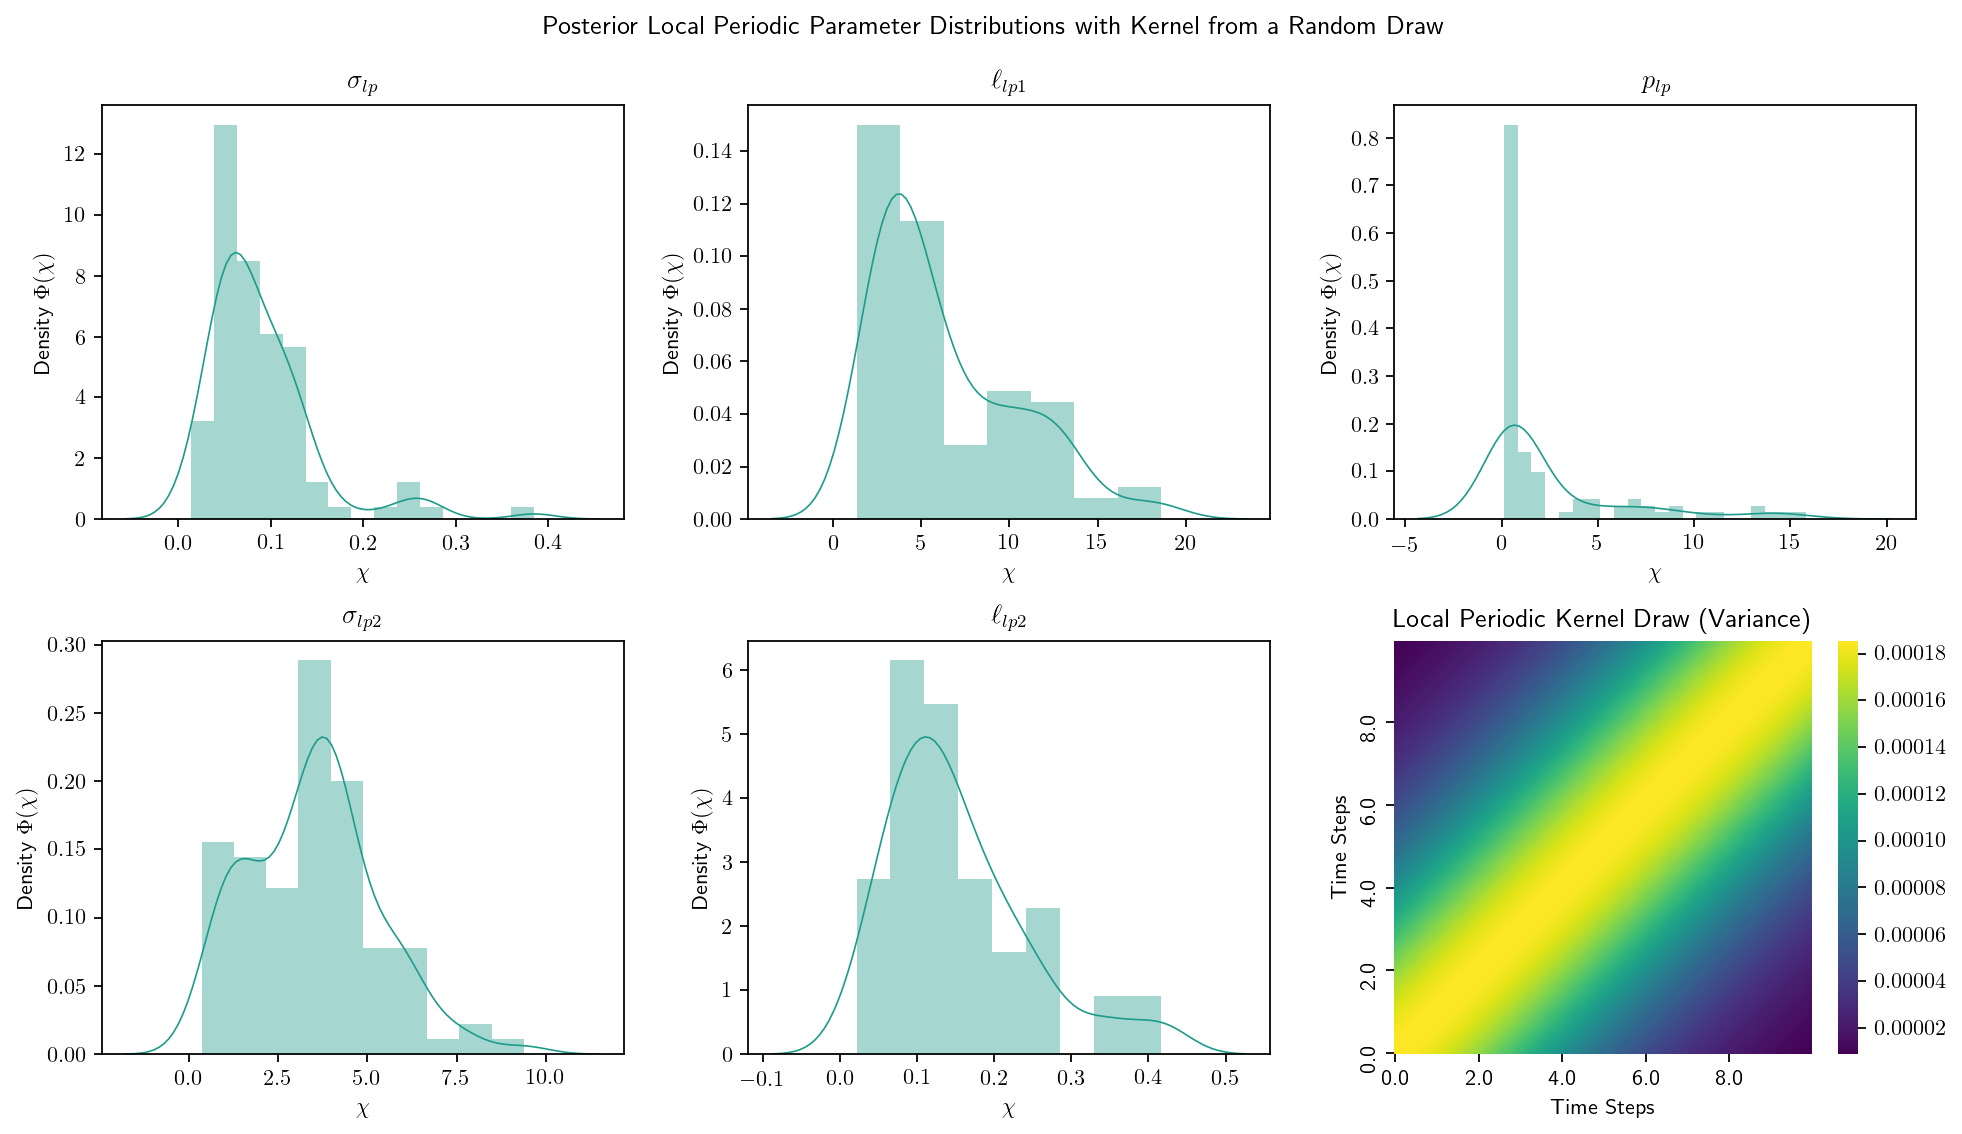

In [36]:
# Local Periodic
local_periodic_kernel = (
        tfk.ExpSinSquared(
            amplitude=periodic_amplitude_samples[0], 
            length_scale=periodic_length_scale_samples[0],
            period=periodic_period_samples[0]) * 
        tfk.ExponentiatedQuadratic(
            amplitude=periodic_local_amplitude_samples[0],
            length_scale=periodic_local_length_scale_samples[0]))

fig, axs = plt.subplots(2, 3, figsize=(12, 7))
plt.tight_layout(h_pad=4.0, w_pad=3.0)
fig.subplots_adjust(top=0.90)
fig.suptitle('Posterior Local Periodic Parameter Distributions with Kernel from a Random Draw')

sns.distplot(periodic_amplitude_samples, norm_hist=True, ax=axs[0,0], kde=True, color=colors[5])
axs[0,0].set_title(r'$\sigma_{lp}$')
sns.distplot(periodic_length_scale_samples, norm_hist=True, ax=axs[0,1], kde=True, color=colors[5])
axs[0,1].set_title(r'$\ell_{lp1}$')
sns.distplot(periodic_period_samples, norm_hist=True, ax=axs[0,2], kde=True, color=colors[5])
axs[0,2].set_title(r'$p_{lp}$')
sns.distplot(periodic_local_amplitude_samples, norm_hist=True, ax=axs[1,1], kde=True, color=colors[5])
axs[1,0].set_title(r'$\sigma_{lp2}$')
sns.distplot(periodic_local_length_scale_samples, norm_hist=True, ax=axs[1,0], kde=True, color=colors[5])
axs[1,1].set_title(r'$\ell_{lp2}$')
plot_kernel(local_periodic_kernel,
            title="Local Periodic Kernel Draw (Variance)",
            xlabel="Time Steps",
            ylabel="Time Steps",
            ax=axs[1,2])

for i, ax in enumerate(axs.flat):
    if i != (len(axs.flat)-1):
        ax.set(xlabel=r'$\chi$', ylabel= r'Density $\Phi(\chi)$')

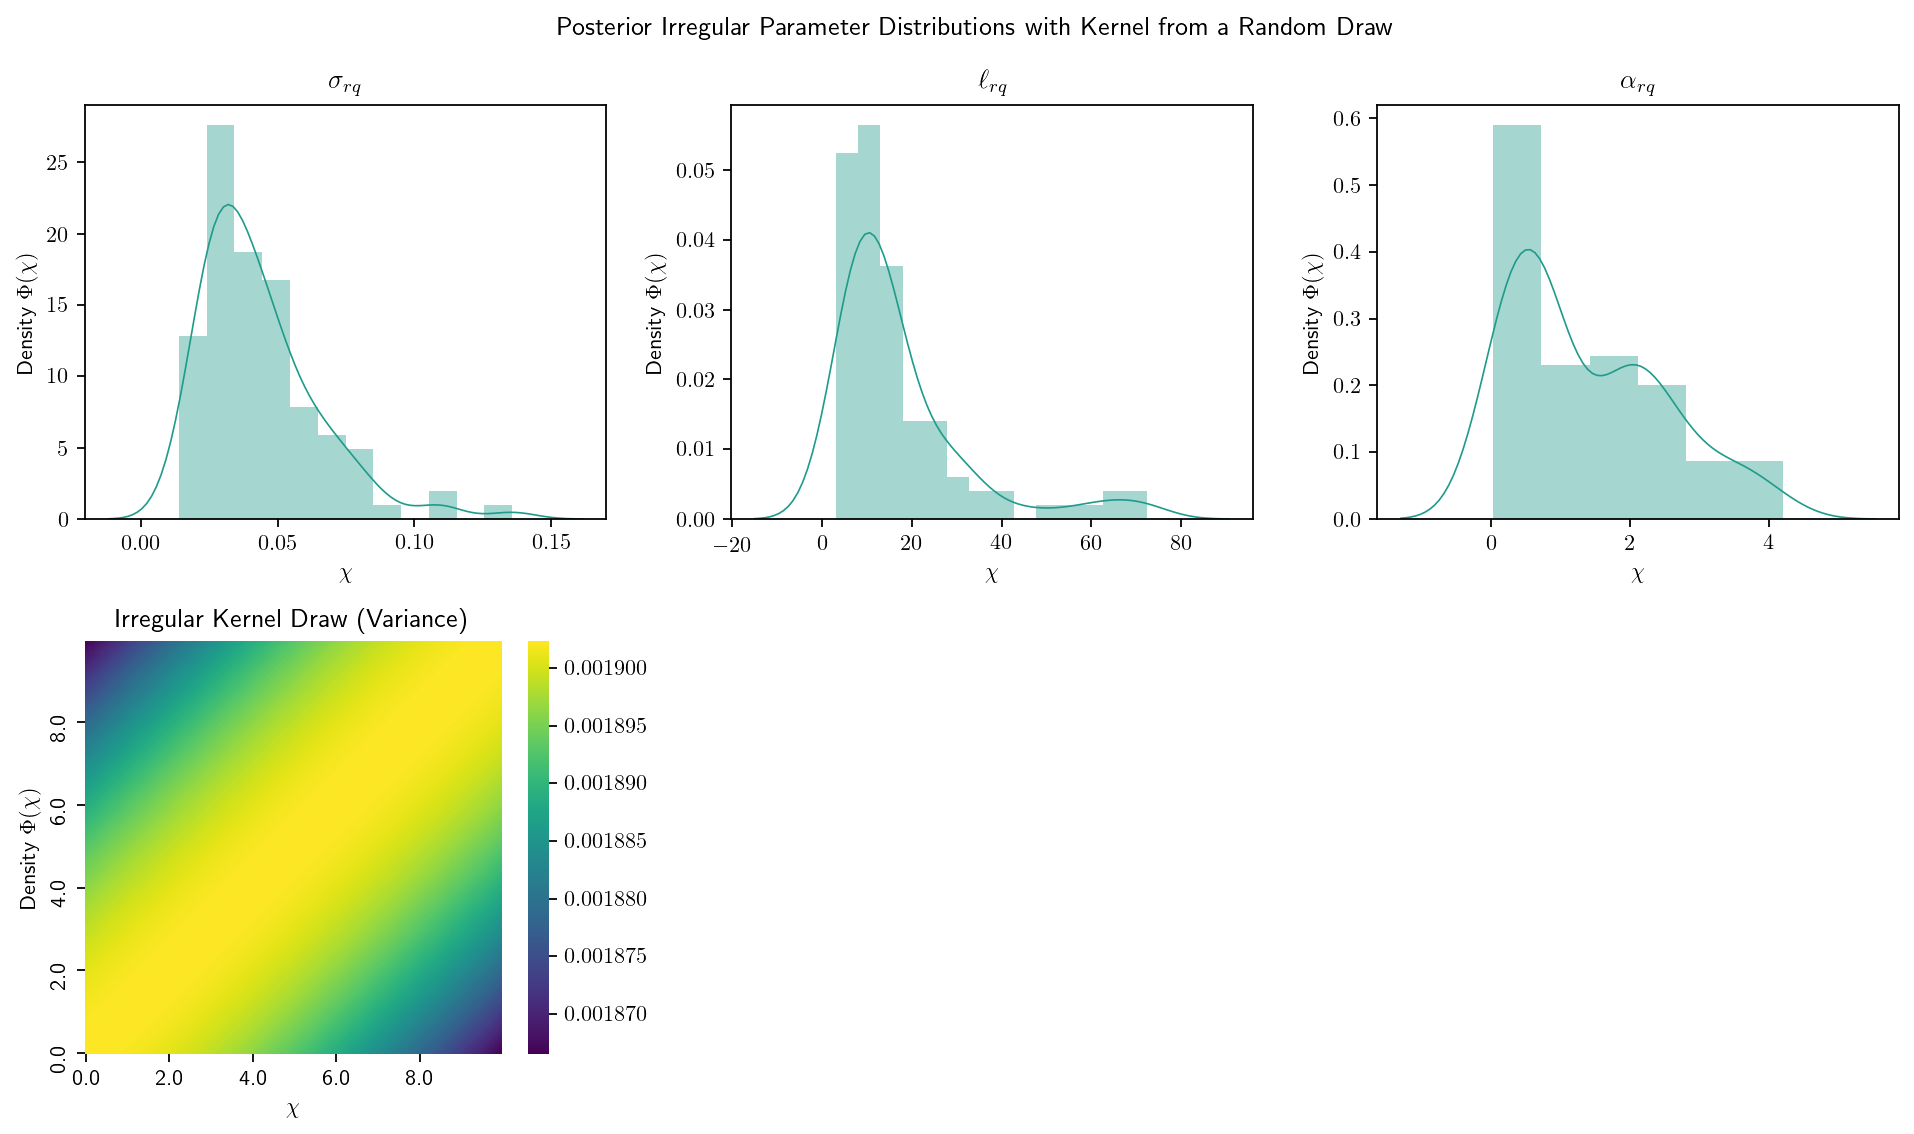

In [37]:
# Irregular
irregular_kernel = tfk.RationalQuadratic(
        amplitude=irregular_amplitude_samples[0],
        length_scale=irregular_length_scale_samples[0],
        scale_mixture_rate=irregular_scale_mixture_samples[0])

fig, axs = plt.subplots(2, 3, figsize=(12, 7))
plt.tight_layout(h_pad=4.0, w_pad=3.0)
fig.subplots_adjust(top=0.90)
fig.suptitle('Posterior Irregular Parameter Distributions with Kernel from a Random Draw')

sns.distplot(irregular_amplitude_samples, norm_hist=True, ax=axs[0,0], kde=True, color=colors[5])
axs[0,0].set_title(r'$\sigma_{rq}$')
sns.distplot(irregular_length_scale_samples, norm_hist=True, ax=axs[0,1], kde=True, color=colors[5])
axs[0,1].set_title(r'$\ell_{rq}$')
sns.distplot(irregular_scale_mixture_samples, norm_hist=True, ax=axs[0,2], kde=True, color=colors[5])
axs[0,2].set_title(r'$\alpha_{rq}$')
plot_kernel(irregular_kernel,
            title="Irregular Kernel Draw (Variance)",
            xlabel="Time Steps",
            ylabel="Time Steps",
            ax=axs[1,0])

for i, ax in enumerate(axs.flat):
    if i != (len(axs.flat)-1):
        ax.set(xlabel=r'$\chi$', ylabel= r'Density $\Phi(\chi)$')
        
fig.delaxes(axs[1,1])
fig.delaxes(axs[1,2])

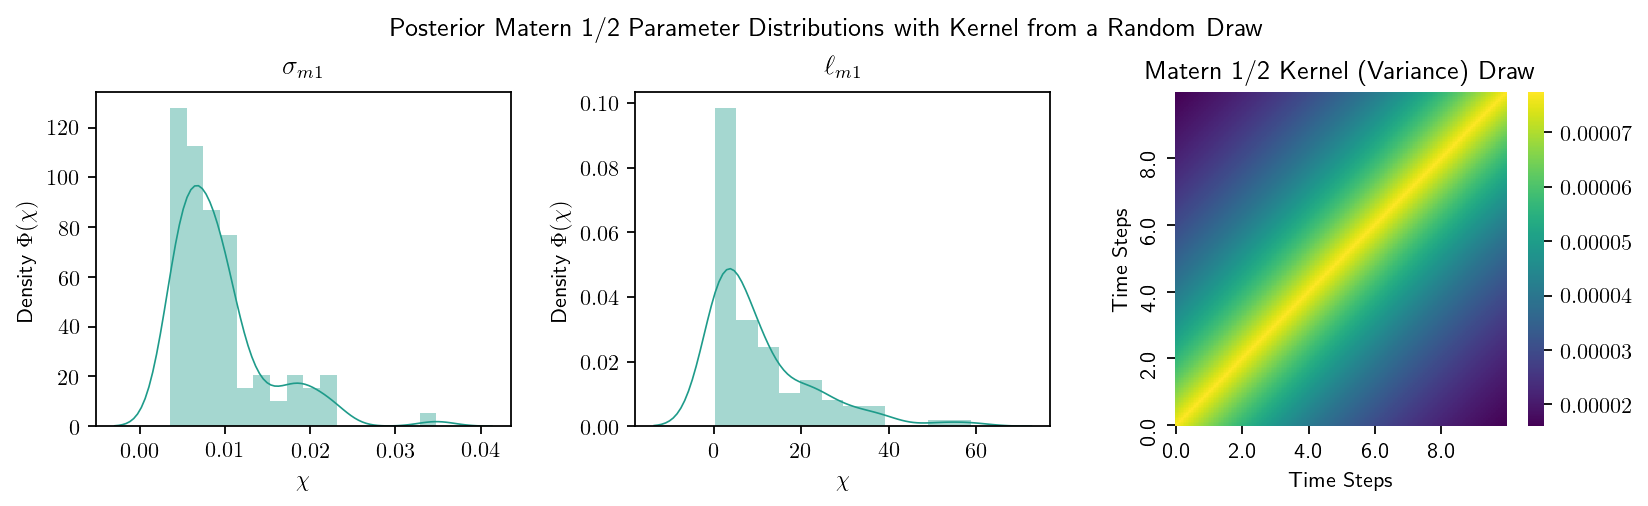

In [38]:
# Matern 1/2
matern_onehalf_kernel = tfk.MaternOneHalf(
        amplitude = matern_onehalf_amplitude_samples[0],
        length_scale = matern_onehalf_scale_samples[0]
    )

fig, axs = plt.subplots(1, 3, figsize=(10, 3))
plt.tight_layout(w_pad=3.0)
fig.subplots_adjust(top=0.82)
fig.suptitle('Posterior Matern 1/2 Parameter Distributions with Kernel from a Random Draw')

sns.distplot(matern_onehalf_amplitude_samples, norm_hist=True, ax=axs[0], kde=True, color=colors[5])
axs[0].set_title(r'$\sigma_{m1}$')
sns.distplot(matern_onehalf_scale_samples, norm_hist=True, ax=axs[1], kde=True, color=colors[5])
axs[1].set_title(r'$\ell_{m1}$')
plot_kernel(matern_onehalf_kernel, title="Matern 1/2 Kernel (Variance) Draw", xlabel="Time Steps", ylabel="Time Steps")

for i, ax in enumerate(axs.flat):
    if i != (len(axs.flat)-1):
        ax.set(xlabel=r'$\chi$', ylabel= r'Density $\Phi(\chi)$')


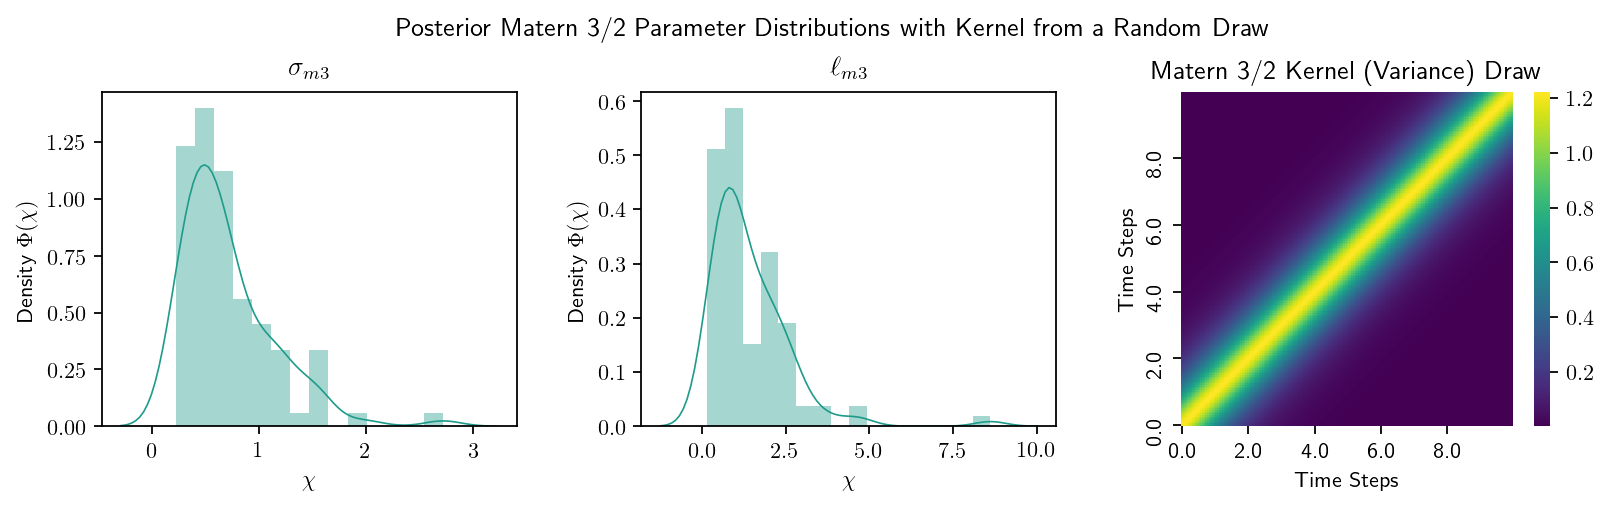

In [39]:
# Matern 3/2
matern_threehalves_kernel = tfk.MaternThreeHalves(
        amplitude = matern_threehalves_amplitude_samples[0],
        length_scale = matern_threehalves_scale_samples[0]
    )

fig, axs = plt.subplots(1, 3, figsize=(10, 3))
plt.tight_layout(w_pad=3.0)
fig.subplots_adjust(top=0.82)
fig.suptitle('Posterior Matern 3/2 Parameter Distributions with Kernel from a Random Draw')

sns.distplot(matern_threehalves_amplitude_samples, norm_hist=True, ax=axs[0], kde=True, color=colors[5])
axs[0].set_title(r'$\sigma_{m3}$')
sns.distplot(matern_threehalves_scale_samples, norm_hist=True, ax=axs[1], kde=True, color=colors[5])
axs[1].set_title(r'$\ell_{m3}$')
plot_kernel(matern_threehalves_kernel, title="Matern 3/2 Kernel (Variance) Draw", xlabel="Time Steps", ylabel="Time Steps")

for i, ax in enumerate(axs.flat):
    if i != (len(axs.flat)-1):
        ax.set(xlabel=r'$\chi$', ylabel= r'Density $\Phi(\chi)$')


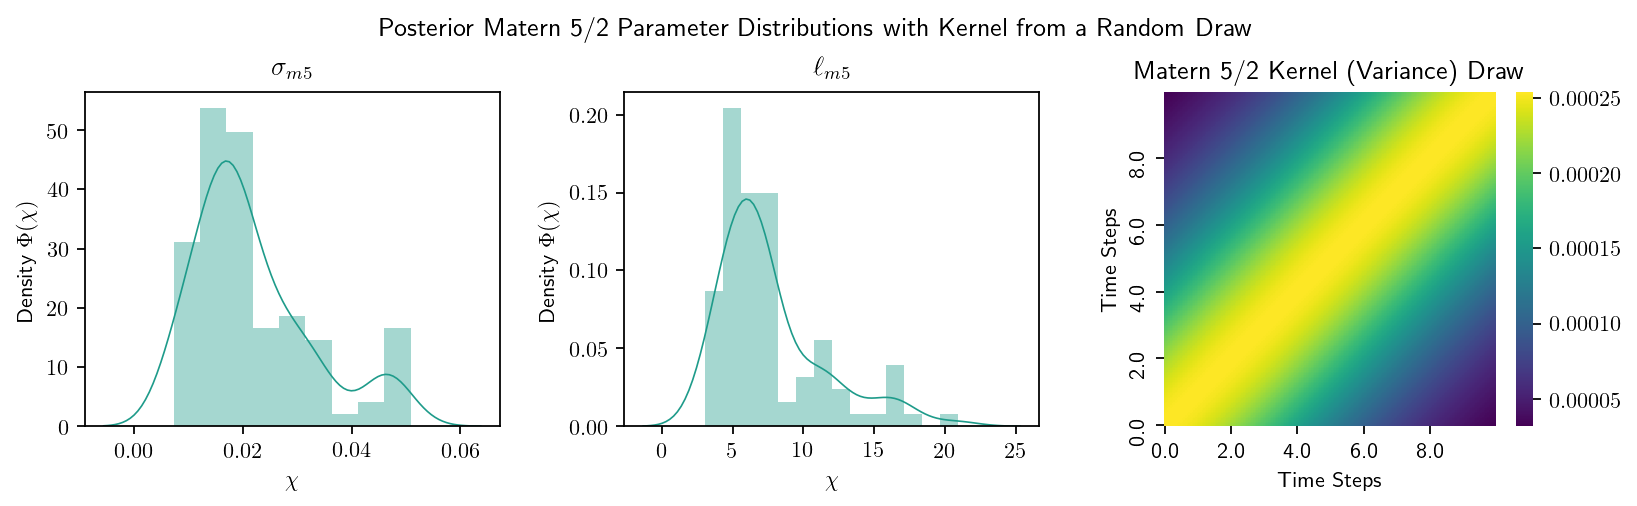

In [40]:
# Matern 5/2
matern_fivehalves_kernel = tfk.MaternFiveHalves(
        amplitude = matern_fivehalves_amplitude_samples[0],
        length_scale = matern_fivehalves_scale_samples[0]
    )

fig, axs = plt.subplots(1, 3, figsize=(10, 3))
plt.tight_layout(w_pad=3.0)
fig.subplots_adjust(top=0.82)
fig.suptitle('Posterior Matern 5/2 Parameter Distributions with Kernel from a Random Draw')

sns.distplot(matern_fivehalves_amplitude_samples, norm_hist=True, ax=axs[0], kde=True, color=colors[5])
axs[0].set_title(r'$\sigma_{m5}$')
sns.distplot(matern_fivehalves_scale_samples, norm_hist=True, ax=axs[1], kde=True, color=colors[5])
axs[1].set_title(r'$\ell_{m5}$')
plot_kernel(matern_fivehalves_kernel, title="Matern 5/2 Kernel (Variance) Draw", xlabel="Time Steps", ylabel="Time Steps")

for i, ax in enumerate(axs.flat):
    if i != (len(axs.flat)-1):
        ax.set(xlabel=r'$\chi$', ylabel= r'Density $\Phi(\chi)$')


In [41]:
predictive_index_points_ = np.linspace(0, N, N, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

In [42]:
%%time
with tf.device('/cpu:0'):

    # The sampled hyperparams have a leading batch dimension, `[num_results, ...]`,
    # so they construct a *batch* of kernels.
    batch_of_posterior_kernels = get_slo_kernel(smooth_amplitude_samples,
                                                smooth_length_scale_samples,
                                                periodic_amplitude_samples,
                                                periodic_length_scale_samples,
                                                periodic_period_samples,
                                                periodic_local_amplitude_samples,
                                                periodic_local_length_scale_samples,
                                                global_periodic_amplitude_samples,
                                                global_periodic_length_scale_samples,
                                                global_periodic_period_samples,
                                                irregular_amplitude_samples,
                                                irregular_length_scale_samples,
                                                irregular_scale_mixture_samples,
                                                matern_onehalf_amplitude_samples,
                                                matern_onehalf_scale_samples,
                                                matern_threehalves_amplitude_samples,
                                                matern_threehalves_scale_samples,
                                                matern_fivehalves_amplitude_samples,
                                                matern_fivehalves_scale_samples)

    # The batch of kernels creates a batch of GP predictive models, one for each
    # posterior sample.
    batch_gprm = tfd.GaussianProcessRegressionModel(
        mean_fn=lambda x: np.mean(Y_train),
        kernel=batch_of_posterior_kernels,
        index_points=predictive_index_points_,
        observation_index_points=X_train,
        observations=Y_train,
        observation_noise_variance=observation_noise_variance_samples,
        predictive_noise_variance=0.)

    # To construct the marginal predictive distribution, we average with uniform
    # weight over the posterior samples.
    predictive_gprm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(logits=tf.zeros([num_results])),
        components_distribution=batch_gprm)

    num_samples = 50
    samples = predictive_gprm.sample(num_samples)

CPU times: user 26.6 s, sys: 26 s, total: 52.6 s
Wall time: 35.6 s


In [43]:
with tf.device('/cpu:0'):

    gp_mean = tf.math.reduce_mean(samples, axis=0).numpy()
    #gp_sd = tf.math.reduce_std(samples, axis=0).numpy()
    gp_variance = tf.linalg.diag_part(
        batch_gprm.covariance(),
        name='diag_part',
        k=0,
        padding_value=0
    )
    #gp_variance = tf.math.square(gp_sd)
    confidence_lower = gp_mean - 1.96 * tf.math.sqrt(gp_variance)
    confidence_upper = gp_mean + 1.96 * tf.math.sqrt(gp_variance)
    prediction_lower = gp_mean - 1.96 * tf.math.sqrt(gp_variance + observation_noise_variance_var)
    prediction_upper = gp_mean + 1.96 * tf.math.sqrt(gp_variance + observation_noise_variance_var)
    
    confidence_lower = tf.math.reduce_mean(confidence_lower, axis=0).numpy()
    confidence_upper = tf.math.reduce_mean(confidence_upper, axis=0).numpy()
    prediction_lower = tf.math.reduce_mean(prediction_lower, axis=0).numpy()
    prediction_upper = tf.math.reduce_mean(prediction_upper, axis=0).numpy()

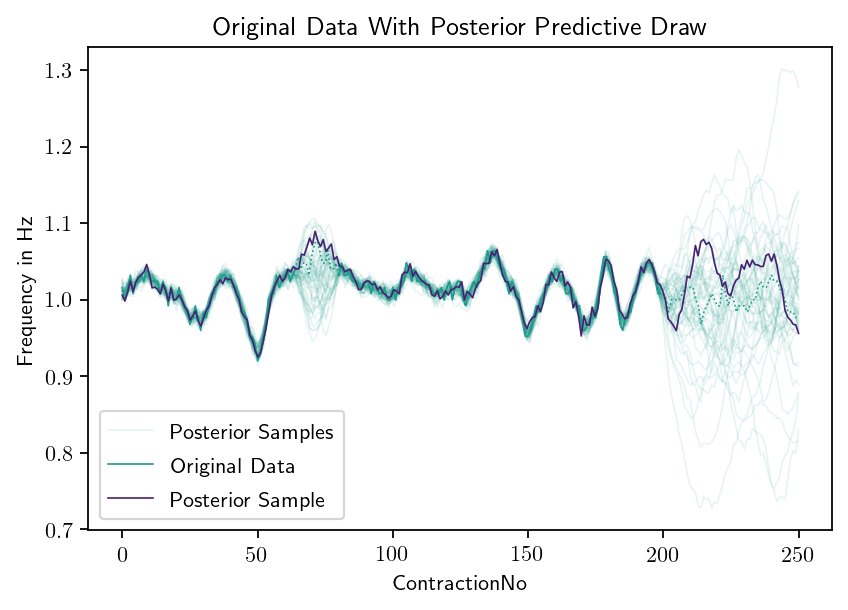

In [44]:
# Samples
for i in range(num_samples):
    plt.plot(predictive_index_points_, samples[i, :], c=colors[5], alpha=0.1,
           label='Posterior Samples' if i == 0 else None)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)

plt.plot(indices_a, part_a, color=colors[5], label="Original Data");
plt.plot(indices_b, part_b, color=colors[5]);
plt.plot(indices_b, part_b, color=colors[5], linestyle=":");
plt.plot(missing_indices_a, missing_a, color=colors[5], linestyle=":");
plt.plot(missing_indices_b, missing_b, color=colors[5], linestyle=":");

plt.plot(predictive_index_points_.flatten(), samples[5], label="Posterior Sample", color=colors[0]);

plt.legend(loc='lower left')
plt.title('Original Data With Posterior Predictive Draw');
plt.ylabel('Frequency in Hz');
plt.xlabel('ContractionNo');

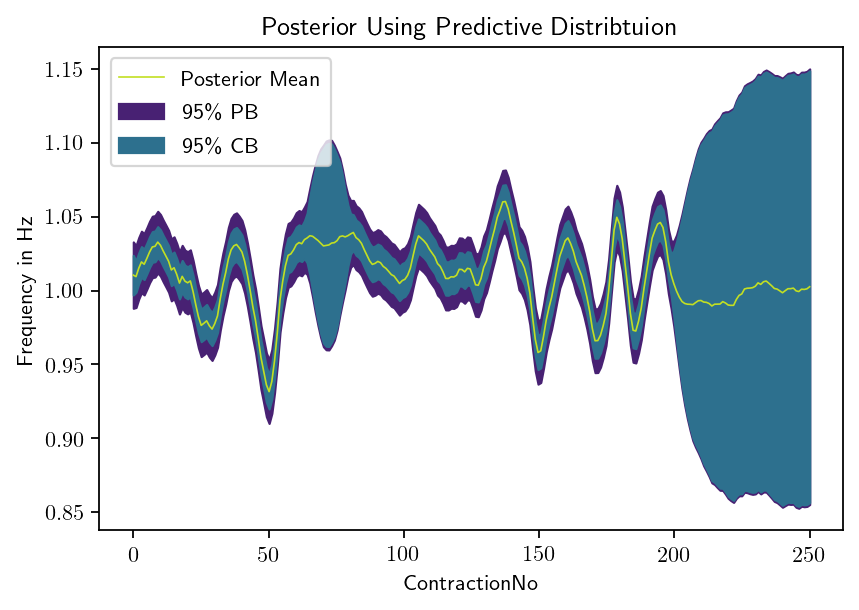

In [45]:
# CB and PB
plt.fill_between(predictive_index_points_.flatten(), prediction_lower, prediction_upper, color=colors[0], alpha=1.0, label="95\% PB")
plt.fill_between(predictive_index_points_.flatten(), confidence_lower, confidence_upper, color=colors[3], alpha=1.0, label="95\% CB")
plt.plot(predictive_index_points_.flatten(), gp_mean, color=colors[9], label="Posterior Mean")
plt.legend(loc='upper left')
plt.title('Posterior Using Predictive Distribtuion');
plt.ylabel('Frequency in Hz');
plt.xlabel('ContractionNo');